# Capstone Project - Car Accident Severity 

## 1. Introduction

Road safety is a serious public concern, thus accident analysis and prediction are significant areas of research. Through data analytics, we are able to extract meaningful information and provide insights on key factors that lead to road accidents. 

Most road accident data collected by government agencies are public available. This project focuses on data obtained from Seattle City to predict the severity of an accident based on time, traffic conditions and other environmental factors. Target audience would be people in charge of developing traffic rules and accident prevention policies. This analysis would also provide practical information to the general public.

## 2. Data Pre-processing

### Load data from path

The dataset contains collision data collected by the Seattle Department of Transportation from 2004 to 2020

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = "https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv"
df = pd.read_csv(path)

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


### Handle missing data

Replace empty values with NaN

In [4]:
df.replace(" ", np.nan, inplace = True)

Identify missing values per column

In [5]:
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

SEVERITYCODE
False    194673
Name: SEVERITYCODE, dtype: int64

X
False    189339
True       5334
Name: X, dtype: int64

Y
False    189339
True       5334
Name: Y, dtype: int64

OBJECTID
False    194673
Name: OBJECTID, dtype: int64

INCKEY
False    194673
Name: INCKEY, dtype: int64

COLDETKEY
False    194673
Name: COLDETKEY, dtype: int64

REPORTNO
False    194673
Name: REPORTNO, dtype: int64

STATUS
False    194673
Name: STATUS, dtype: int64

ADDRTYPE
False    192747
True       1926
Name: ADDRTYPE, dtype: int64

INTKEY
True     129603
False     65070
Name: INTKEY, dtype: int64

LOCATION
False    191996
True       2677
Name: LOCATION, dtype: int64

EXCEPTRSNCODE
True     189035
False      5638
Name: EXCEPTRSNCODE, dtype: int64

EXCEPTRSNDESC
True     189035
False      5638
Name: EXCEPTRSNDESC, dtype: int64

SEVERITYCODE.1
False    194673
Name: SEVERITYCODE.1, dtype: int64

SEVERITYDESC
False    194673
Name: SEVERITYDESC, dtype: int64

COLLISIONTYPE
False    189769
True       4904
Name: C

The dataset has missing data that needed to be dealt with. JUNCTIONTYPE, WEATHER, ROADCOND, and LIGHTCOND have observations classified as ‘Unknown’. The missing values are practically unknown values, so it made sense to replace the values with the same class. Observations for ADDRTYPE and COLLISIONTYPE were dropped as the most frequent values for each column were not high enough in count percentage to replace the missing values. All other attributes not relevant to my analysis were dropped. 

In [6]:
#replace with related value
df["JUNCTIONTYPE"].replace(np.nan, "Unknown", inplace=True)
df["WEATHER"].replace(np.nan, "Unknown", inplace=True)
df["ROADCOND"].replace(np.nan, "Unknown", inplace=True)
df["LIGHTCOND"].replace(np.nan, "Unknown", inplace=True)

#drop rows
df.dropna(subset=['ADDRTYPE'], axis=0, inplace=True)
df.dropna(subset=['COLLISIONTYPE'], axis=0, inplace=True)

#drop columns
df.drop(['X','Y','INTKEY','LOCATION','EXCEPTRSNCODE','EXCEPTRSNDESC','INATTENTIONIND','UNDERINFL','PEDROWNOTGRNT','SDOTCOLNUM','SPEEDING','ST_COLDESC', 'ST_COLCODE'],axis=1,inplace=True)

#reset index
df.reset_index(drop=True, inplace=True)

### Class Imbalance: Under-sampling the Majority Class

Imbalanced classes have a negative impact on the accuracy of our models. This occurs when there is a disproportionate ratio of observations in each class. In our dataset, there are obviously more observations for accidents resulting to property damage (Severity Code = 1) than accidents resulting to injury (Severity Code = 2).

In [7]:
df['SEVERITYCODE'].value_counts()

1    130973
2     56977
Name: SEVERITYCODE, dtype: int64

To fix the imbalance, I decided to under-sample the data by randomly removing observations from the majority class to match the number of observations for the minority class.

In [8]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.SEVERITYCODE==1]
df_minority = df[df.SEVERITYCODE==2]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=56977,  # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.SEVERITYCODE.value_counts()

2    56977
1    56977
Name: SEVERITYCODE, dtype: int64

### Convert to proper format

In [9]:
df_downsampled.dtypes

SEVERITYCODE       int64
OBJECTID           int64
INCKEY             int64
COLDETKEY          int64
REPORTNO          object
STATUS            object
ADDRTYPE          object
SEVERITYCODE.1     int64
SEVERITYDESC      object
COLLISIONTYPE     object
PERSONCOUNT        int64
PEDCOUNT           int64
PEDCYLCOUNT        int64
VEHCOUNT           int64
INCDATE           object
INCDTTM           object
JUNCTIONTYPE      object
SDOT_COLCODE       int64
SDOT_COLDESC      object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
SEGLANEKEY         int64
CROSSWALKKEY       int64
HITPARKEDCAR      object
dtype: object

In [10]:
df_downsampled['INCDATE'] = pd.to_datetime(df_downsampled['INCDATE'])
df_downsampled['INCDTTM'] = pd.to_datetime(df_downsampled['INCDTTM'])

### Data Visualisation

Let's plot some columns to understand the data

In [11]:
df_downsampled['HOUROFDAY'] = df_downsampled['INCDTTM'].dt.hour
df_downsampled['DAYOFWEEK'] = df_downsampled['INCDTTM'].dt.dayofweek
df_downsampled['YEAR'] = df_downsampled['INCDATE'].dt.year

Bar plots

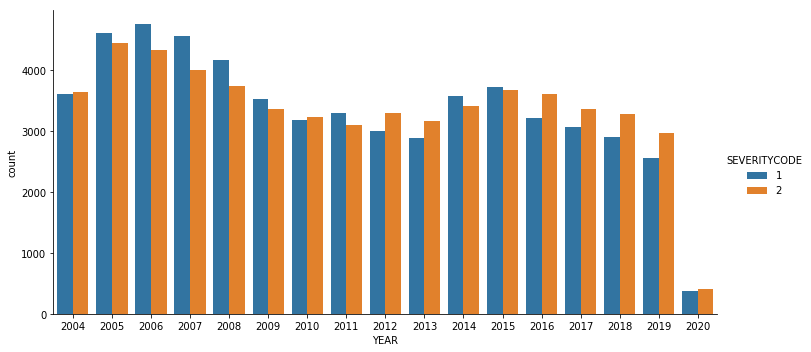

In [20]:
sns.catplot(x='YEAR', kind='count', hue='SEVERITYCODE', data=df_downsampled,  aspect=2)

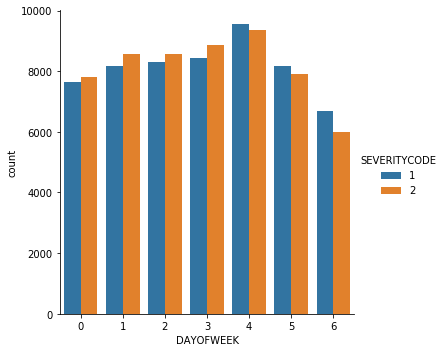

In [21]:
sns.catplot(x='DAYOFWEEK', kind='count', hue='SEVERITYCODE', data=df_downsampled)

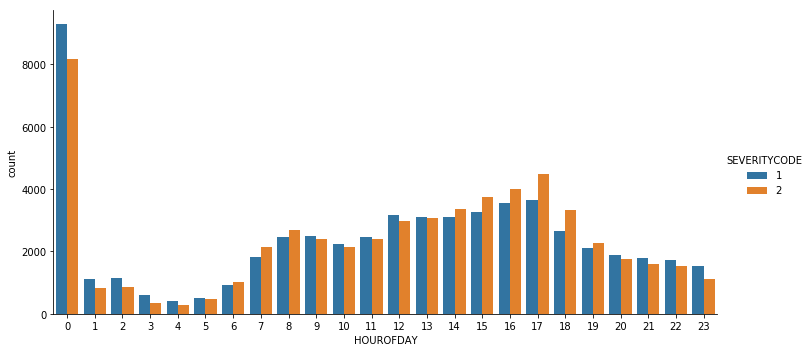

In [24]:
sns.catplot(x='HOUROFDAY', kind='count', hue='SEVERITYCODE', data=df_downsampled, height=5, aspect=2)

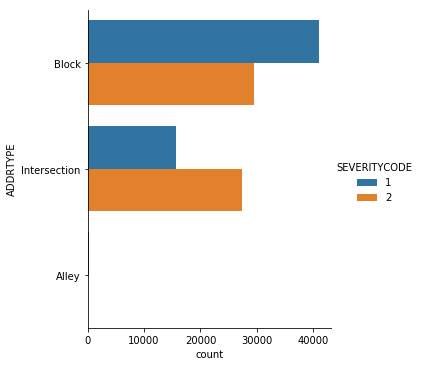

In [25]:
sns.catplot(y='ADDRTYPE', kind='count', hue='SEVERITYCODE', data=df_downsampled)

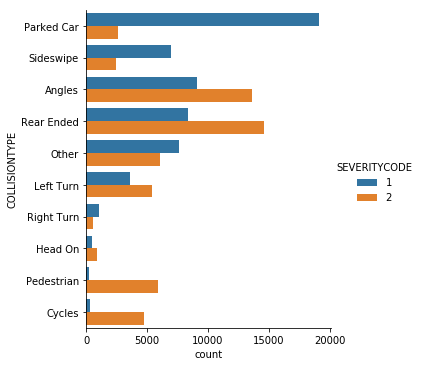

In [26]:
sns.catplot(y='COLLISIONTYPE', kind='count', hue='SEVERITYCODE', data=df_downsampled)

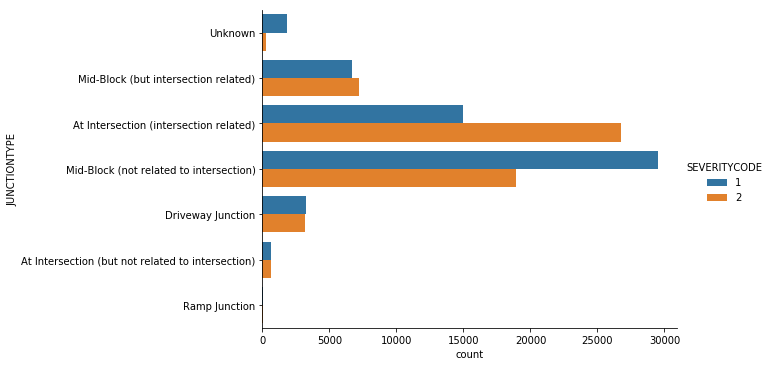

In [28]:
sns.catplot(y='JUNCTIONTYPE', kind='count', hue='SEVERITYCODE', data=df_downsampled, height=5, aspect=2)

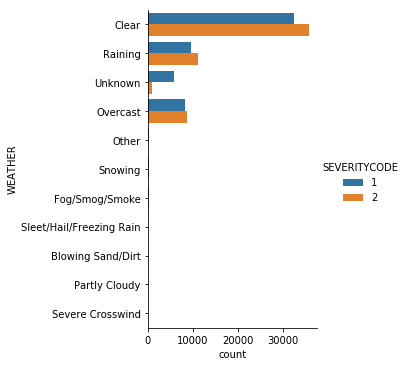

In [17]:
sns.catplot(y='WEATHER', kind='count', hue='SEVERITYCODE', data=df_downsampled)

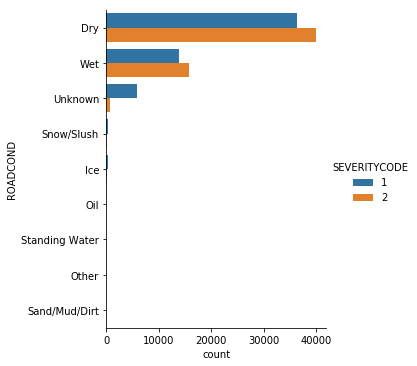

In [18]:
sns.catplot(y='ROADCOND', kind='count', hue='SEVERITYCODE', data=df_downsampled)

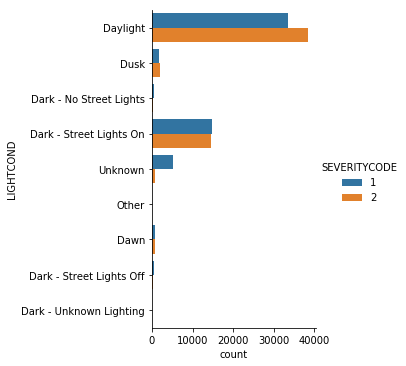

In [19]:
sns.catplot(y='LIGHTCOND', kind='count', hue='SEVERITYCODE', data=df_downsampled)

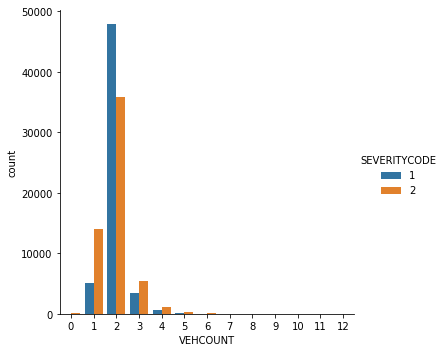

In [30]:
sns.catplot(x='VEHCOUNT', kind='count', hue='SEVERITYCODE', data=df_downsampled)

### One Hot Encoding

The dataset mostly contains categorical data. Most machine learning algorithms cannot operate on categorical data directly, therefore these were converted to numerical data using one hot encoding technique.

In [31]:
attributes = df_downsampled[['ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']]
Feature = pd.concat([pd.get_dummies(attributes), df_downsampled[['VEHCOUNT', 'HOUROFDAY', 'DAYOFWEEK']]], axis=1)

### Feature Selection

After pre-processing the data, 113,954 samples remained with 52 features (which increased due to one hot encoding). Some attributes were duplicates or redundant in value, while others were not relevant to my analysis. I’m particularly interested in attributes that relate to time and space, thus attributes influenced by human behaviour were removed. 

In [32]:
Feature.shape

(113954, 52)

In [33]:
X = Feature.values
y = df_downsampled['SEVERITYCODE'].values

### Normalize Data

In [34]:
from sklearn import preprocessing

X = preprocessing.StandardScaler().fit(X).transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 3. Modeling

The goal of this project is to predict the class of the target variable. For this reason, I used classification algorithms.

### Train/Test Split

Split the dataset into training and testing sets to provide a more accurate evaluation on out-of-sample accuracy.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (91163, 52) (91163,)
Test set: (22791, 52) (22791,)


### Random Forest

A random forest merges multiple decision trees together to obtain a more accurate prediction. It also allows to easily measure the importance of each feature on the prediction. I decided to use this algorithm as tree ensembles usually outperform singular decision trees.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [57]:
# Train model
RF = RandomForestClassifier(n_estimators=100, criterion='entropy',max_depth =10, random_state=100)
RF.fit(X_train, y_train)
 
print("Accuracy score (training): {0:.3f}".format(RF.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(RF.score(X_test, y_test)))

Accuracy score (training): 0.711
Accuracy score (validation): 0.703


### Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

In [58]:
GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=0.75,  max_depth=4, random_state=0)
GBC.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(GBC.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(GBC.score(X_test, y_test)))

Accuracy score (training): 0.720
Accuracy score (validation): 0.701


## 4. Evaluation

In [40]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

In [41]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

### Random Forest

In [48]:
# Predict on training set
pred_RF = RF.predict(X_test)
 
# Accuracy
print("Accuracy: ", metrics.accuracy_score(y_test, pred_RF))

Accuracy:  0.7026896581984117


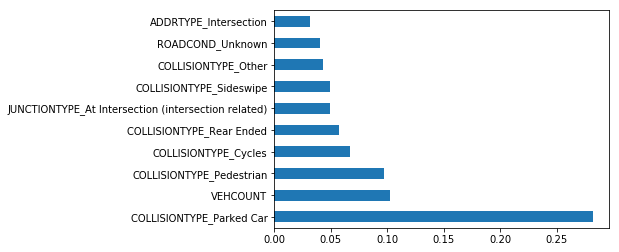

In [49]:
feat_importances = pd.Series(RF.feature_importances_, index=Feature.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Confusion matrix, without normalization
[[7109 4290]
 [2486 8906]]


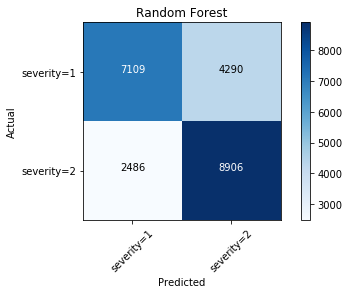

In [50]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_RF, labels=[1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['severity=1','severity=2'],normalize= False,  title='Random Forest')

In [51]:
print("Random Forest Jaccard index: %.2f" % jaccard_similarity_score(y_test, pred_RF))
print("Random Forest F1-score: %.2f" % f1_score(y_test, pred_RF, average='weighted'))
print(classification_report(y_test, pred_RF))

Random Forest Jaccard index: 0.70
Random Forest F1-score: 0.70
              precision    recall  f1-score   support

           1       0.74      0.62      0.68     11399
           2       0.67      0.78      0.72     11392

   micro avg       0.70      0.70      0.70     22791
   macro avg       0.71      0.70      0.70     22791
weighted avg       0.71      0.70      0.70     22791



### Gradient Boosting

In [52]:
GBC.fit(X_train, y_train)
pred_GBC = GBC.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(y_test, pred_GBC))

Accuracy:  0.7009345794392523


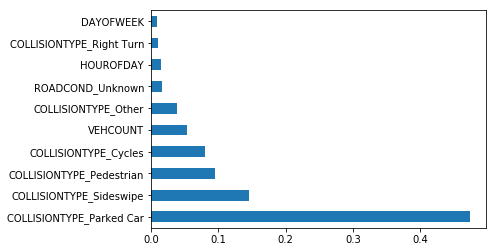

In [53]:
feat_importances = pd.Series(GBC.feature_importances_, index=Feature.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Confusion matrix, without normalization
[[6895 4504]
 [2312 9080]]


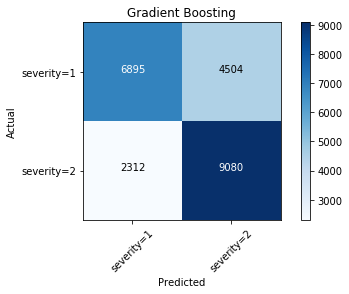

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_GBC, labels=[1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['severity=1','severity=2'],normalize= False,  title='Gradient Boosting')

In [55]:
print("GBC Jaccard index: %.2f" % jaccard_similarity_score(y_test, pred_GBC))
print("GBC F1-score: %.2f" % f1_score(y_test, pred_GBC, average='weighted'))
print(classification_report(y_test, pred_GBC))

GBC Jaccard index: 0.70
GBC F1-score: 0.70
              precision    recall  f1-score   support

           1       0.75      0.60      0.67     11399
           2       0.67      0.80      0.73     11392

   micro avg       0.70      0.70      0.70     22791
   macro avg       0.71      0.70      0.70     22791
weighted avg       0.71      0.70      0.70     22791



## 5. Results

| Algorithm          | Jaccard | Precision | Recall | F1-score | 
|--------------------|---------|-----------|--------|----------|
| Random Forest      | 0.70    |    0.71   |  0.70  |0.71     |
| Gradient Boosting  | 0.70    |    0.71   |  0.70  |0.71     |
